In [274]:
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import regex as re
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.linear_model import Ridge


## Inroduction
Le but de ce notebook est de produire une solution simple qui traite un ensemble des données collectées (Experiences clients: EC) pendant un questionnaire effectué sur les transports en commun à la région Nouvelle Aquitaine. Une fois traitées, ces données seront données à différents modeles de machine learning afin de prédire la satisfaction du client (NPS)

## 1 - Load Data
Les données collectées sont regroupées dans le fichier NA-data.csv 
Ces données sont donc télécharger et mis sous forme de Dataframe.

In [275]:
#loading the data
data = pd.read_csv("NA-data.csv")
data.head()

,Horodateur,Quel âge avez-vous ?,De quel département êtes-vous ?,Comment décririez-vous votre usage des transports routiers en NA ?,Quels sont vos usages de transport en commun,À quelle fréquence utilisez-vous les transports routiers de votre région ?,Quelle application utilisez-vous pour réaliser un itinéraire de transport ?,Saviez-vous que vous pouviez réaliser un itinéraire depuis le portail de la Nouvelle Aquitaine ?,"Aller sur le site transport de la NA, puis indiquez quelle est votre niveau appréciation globale du portail ?","En allant sur le portail de la nouvelle Aquitaine, quelles sont les informations que vous souhaiteriez trouver ?",...,3,4,5,6,7,8,9,10,Quelle est la probabilité que vous recommandiez le portail de la Nouvelle Aquitaine à un ami ou un collègue ?,"Souhaitez-vous partager un commentaire, remarque ou suggestion ?"
0,10/4/2021 12:37:21,37,33,Utilisait TBM pour faire des itinéraires et vo...,NaN,NaN,"Google map, TBM","Non, je ne le savais pas",3,\r\nN'est pas jamais aller - ne savait même pa...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10/4/2021 18:15:12,24 ans,33,Très peu \r\nLe de temps en temps ex 5 c par s...,NaN,NaN,"Google map, TBM","Non, je ne le savais pas",3,Horaires \r\nTrajets \r\nTarifs pour les sévic...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10/4/2021 18:28:10,30,33,N'utilise pas - voir le moins possible,NaN,NaN,"Google map, TBM","Non, je ne le savais pas",3,Horaires\r\nItinéraire \r\nPrix \r\nbouchon/ c...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10/11/2021 18:39:13,27,33,1 fois par mois,Activités de la vie quotidienne (aller au spor...,NaN,"TBM, Google map, Le portail de la Nouvelle Aqu...",NaN,1,Achat de billet en ligne sans devoir faire val...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10/12/2021 10:50:13,23,33,Peu fréquent,Activités de la vie quotidienne (aller au spor...,Quelques fois par mois,"TBM, Google map, SNCF ou OuïGo","Non, je ne le savais pas",4,Des itinéraires avec les temps les plus courts...,...,5.0,1.0,5.0,2.0,4.0,1.0,5.0,1.0,6.0,NaN


## 2 - Discover Data
Dans cette étape on utilise des méthodes de dataframe pour découvrir et se familiariser avec nos données. 

In [276]:
#Checking the shape of the dataset
data.shape

(27, 29)

In [277]:
#Listing the features of the dataset
data.columns

Index(['Horodateur', 'Quel âge avez-vous ?', 'De quel département êtes-vous ?',
       'Comment décririez-vous votre usage des transports routiers en NA ?',
       'Quels sont vos usages de transport en commun',
       'À quelle fréquence utilisez-vous les transports routiers de votre région ?',
       'Quelle application utilisez-vous pour réaliser un itinéraire de transport ?',
       'Saviez-vous que vous pouviez réaliser un itinéraire depuis le portail de la Nouvelle Aquitaine ? ',
       ' Aller sur le site transport de la NA, puis indiquez quelle est votre niveau appréciation globale du portail ?',
       'En allant sur le portail de la nouvelle Aquitaine, quelles sont les informations que vous souhaiteriez trouver ?',
       'Que pensez-vous de l’esthétisme du site ?',
       'Pourriez-vous simuler un itinéraire,  puis évaluer votre niveau de satisfaction du service',
       'Qu’est-ce que vous avez apprécié ?',
       'Qu’est-ce que vous avez le plus aimé dans le design du site

In [278]:
#Information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 29 columns):
 #   Column                                                                                                            Non-Null Count  Dtype  
---  ------                                                                                                            --------------  -----  
 0   Horodateur                                                                                                        27 non-null     object 
 1   Quel âge avez-vous ?                                                                                              27 non-null     object 
 2   De quel département êtes-vous ?                                                                                   27 non-null     int64  
 3   Comment décririez-vous votre usage des transports routiers en NA ?                                                27 non-null     object 
 4   Quels sont vos usages de transport

## 3 - First data preparation
D'après notre connaissance actuel des différents attributs de notre dataframe, on va faire une petite préparation qui consiste à supprimer certaines colonnes qui contiennent des réponses textuelles longues, et qui ne seront pas utiles pour notre approche actuelle. Ensuite on va renommer nos attributs pour faciliter leurs utilisations.

In [279]:
#drop features that contain long text answers (useless for the moment)
data = data.drop(['Horodateur','Comment décririez-vous votre usage des transports routiers en NA ?','En allant sur le portail de la nouvelle Aquitaine, quelles sont les informations que vous souhaiteriez trouver ?','Qu’est-ce que vous avez apprécié ?','Qu’est-ce que vous avez le plus aimé dans le design du site ?','Qu’est-ce que tu avez le moins aimé dans le design du site ?',"Comment pourrions-nous améliorer le portail d'un point de vue accessibilité ?",'sus items','Souhaitez-vous partager un commentaire, remarque ou suggestion ?'],axis=1)

In [280]:
#change the columns names for easy usage
dict = {'Quel âge avez-vous ?': 'Age',
        'Quels sont vos usages de transport en commun': 'Usages',
        'De quel département êtes-vous ?': 'Dépratement',
        'À quelle fréquence utilisez-vous les transports routiers de votre région ?': 'Fréquence',
        'Quelle application utilisez-vous pour réaliser un itinéraire de transport ?':'Apps',
        'Saviez-vous que vous pouviez réaliser un itinéraire depuis le portail de la Nouvelle Aquitaine ? ': 'Itinéraire',
        ' Aller sur le site transport de la NA, puis indiquez quelle est votre niveau appréciation globale du portail ?': 'Appréciation-portail',
        'Que pensez-vous de l’esthétisme du site ?': 'Esthétisme',
        'Pourriez-vous simuler un itinéraire,  puis évaluer votre niveau de satisfaction du service': 'Itinéraire-satisfaction',
        'Quelle est la probabilité que vous recommandiez le portail de la Nouvelle Aquitaine à un ami ou un collègue ? ': 'NPS',
        '1':'Utilisation-fréquente',
        '2':'systeme-complexe',
        '3':'systeme-facile',
        '4':'support-specialiste',
        '5':'fonctions-intégrées',
        '6':'systeme_incoherent',
        '7':'facile-apprendre',
        '8':'systeme-contraignant',
        '9':'confiance',
        '10':'familiarisation-difficile',
        }
data.rename(columns=dict,
          inplace=True)
data.columns

Index(['Age', 'Dépratement', 'Usages', 'Fréquence', 'Apps', 'Itinéraire',
       'Appréciation-portail', 'Esthétisme', 'Itinéraire-satisfaction',
       'Utilisation-fréquente', 'systeme-complexe', 'systeme-facile',
       'support-specialiste', 'fonctions-intégrées', 'systeme_incoherent',
       'facile-apprendre', 'systeme-contraignant', 'confiance',
       'familiarisation-difficile', 'NPS'],
      dtype='object')

In [281]:
#new data shape
data.shape

(27, 20)

## 4 - Visualize the data
Quelques graphiques sont affichés pour déterminer comment les données sont distribuées et comment les attributs sont liés les uns aux autres.

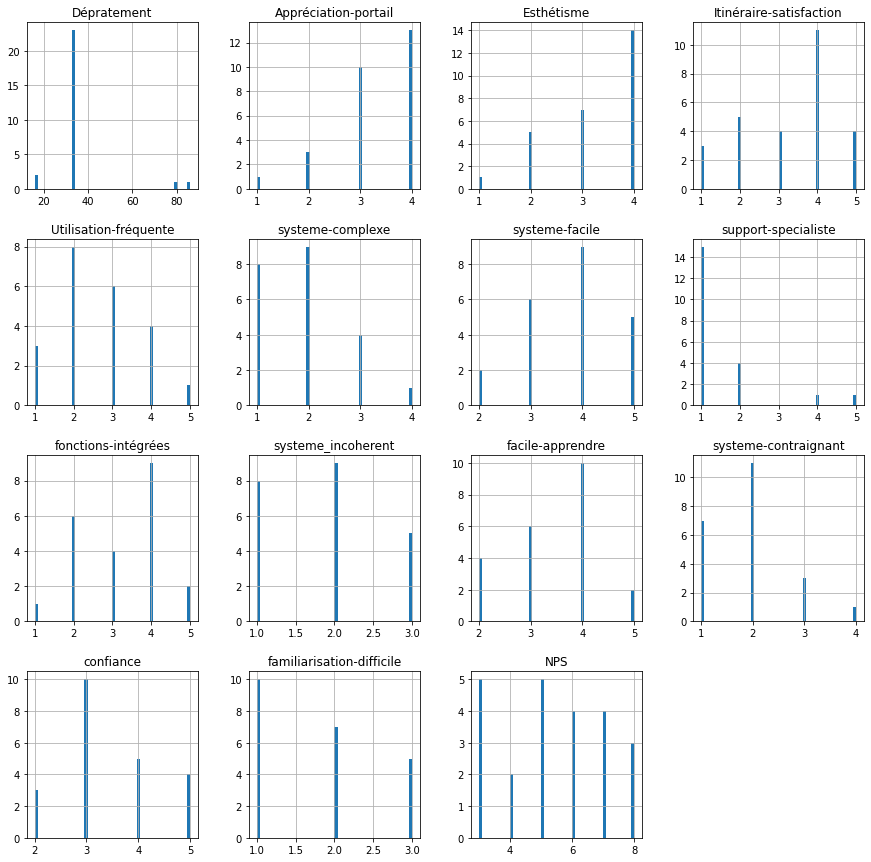

In [282]:
#Plotting the data distribution
data.hist(bins = 50,figsize = (15,15))
plt.show()

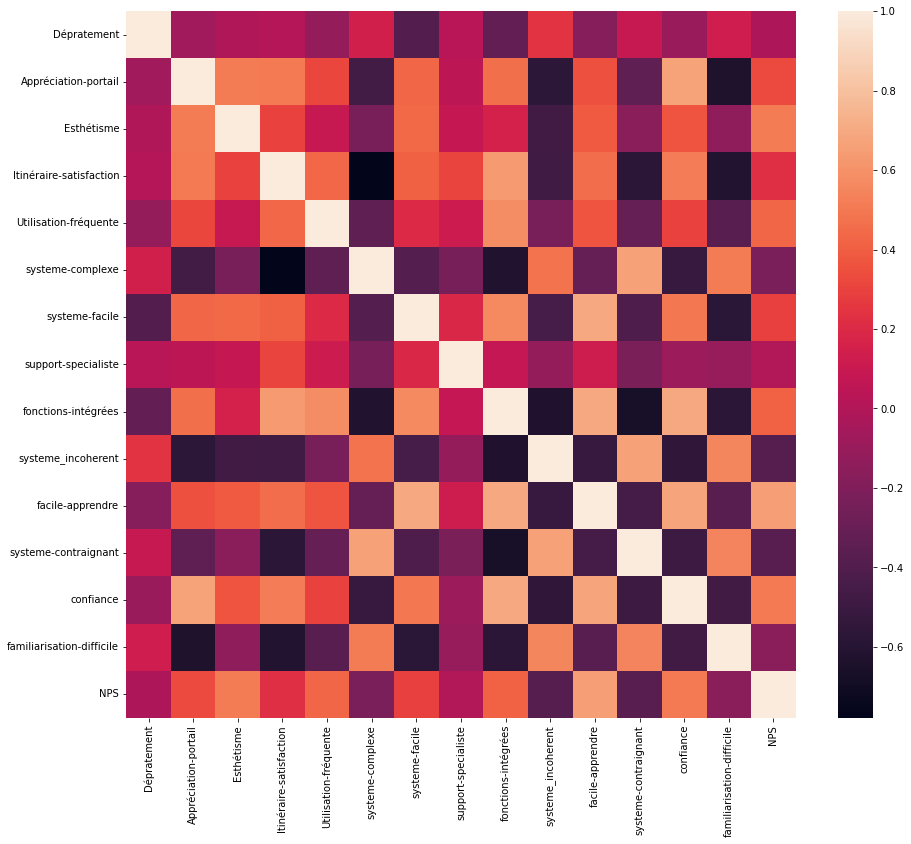

In [283]:
#Correlation heatmap

plt.figure(figsize=(15,13))
sns.heatmap(data.corr())
plt.show()

## 5 -  Data Preprocessing & EDA
Ici, nous nettoyons les données en appliquant des techniques de prétraitement des données et en les transformant pour les utiliser dans nos prochains modèles.

In [284]:
data.describe()

,Dépratement,Appréciation-portail,Esthétisme,Itinéraire-satisfaction,Utilisation-fréquente,systeme-complexe,systeme-facile,support-specialiste,fonctions-intégrées,systeme_incoherent,facile-apprendre,systeme-contraignant,confiance,familiarisation-difficile,NPS
count,27.000000,27.000000,27.000000,27.000000,22.000000,22.000000,22.000000,21.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,23.000000
mean,35.444444,3.296296,3.259259,3.296296,2.636364,1.909091,3.772727,1.523810,3.227273,1.863636,3.454545,1.909091,3.454545,1.772727,5.391304
std,14.289139,0.823446,0.902671,1.265361,1.093071,0.867898,0.922307,1.077917,1.109776,0.774317,0.911685,0.811177,0.962500,0.812510,1.725191
min,16.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,3.000000
25%,33.000000,3.000000,3.000000,2.000000,2.000000,1.000000,3.000000,1.000000,2.000000,1.000000,3.000000,1.000000,3.000000,1.000000,4.000000
50%,33.000000,3.000000,4.000000,4.000000,2.500000,2.000000,4.000000,1.000000,3.500000,2.000000,4.000000,2.000000,3.000000,2.000000,5.000000
75%,33.000000,4.000000,4.000000,4.000000,3.000000,2.000000,4.000000,2.000000,4.000000,2.000000,4.000000,2.000000,4.000000,2.000000,7.000000
max,86.000000,4.000000,4.000000,5.000000,5.000000,4.000000,5.000000,5.000000,5.000000,3.000000,5.000000,4.000000,5.000000,3.000000,8.000000


D'après ces résultats, on peut tirer les remarques et les objectifs suivants:
- Certaines instances n'ont pas de valeurs de NPS, donc vaut mieux les supprimer, car elles seront inutiles pour notre apprentissage suppervisé.
- La colonne de l'age doit être traitée pour extraire que la valeur numérique.
- Gérer les colonnes contenant des réponses textes (des choix multiples ...) en utilisant une méthode d'encodage.
- Faire un pipeline regroupant l'ensemble de transformations (standarisation des données + remplir les valeurs manquantes)  

In [285]:
#drop rows that dont contain NPS and split data (features + Label)
data = data.drop(index=[0,1,2,3], axis=0)
data = data.reset_index()
data = data.drop(['index'],axis=1)


In [286]:
#process age column
def processAge(ages):
    for i in range(len(ages)):
        ages[i] = int(re.sub(r'(?P<age>[0-9]+).*',r"\g<age>",ages[i]))
    return ages
processAge(data['Age'])
        

C:\Users\houss\AppData\Local\Temp/ipykernel_5356/3550480586.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ages[i] = int(re.sub(r'(?P<age>[0-9]+).*',r"\g<age>",ages[i]))


0     23
1     37
2     30
3     24
4     27
5     70
6     70
7     16
8     40
9     28
10    38
11    54
12    45
13    36
14    29
15    41
16    46
17    41
18    51
19    68
20    39
21    42
22    35
Name: Age, dtype: object

In [287]:
#processing text features: Itinéraire and Fréquence
pipeline = Pipeline([
("imp", SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
("cat", OrdinalEncoder(categories=[['Non, je ne le savais pas', 'Oui, je le savais'],['Plusieurs fois par semaine', 'Quelques fois par an',
        'Quelques fois par mois','Jamais']]))
])

Itinieraire_frequence_pipeline = ColumnTransformer([
("cat", pipeline, ["Itinéraire","Fréquence"]),
])

data_prepared = Itinieraire_frequence_pipeline.fit_transform(data)
data[['Itinéraire','Fréquence']] = pd.DataFrame(data_prepared, columns=['Itinéraire','Fréquencé'], index=data.index)

In [288]:
#processing text features: Usages and Apps
mlb = MultiLabelBinarizer()
mlb2 = MultiLabelBinarizer()
pattern = re.compile('(?<!sport|courses), ')
classes = ['Activités de la vie quotidienne (aller au sport, faire les courses, ...)',
       'Déplacement professionnel occasionnel',
       'Déplacement professionnel quotidien', 'Tourisme','Transport scolaire']

def processUsagesApps(df):
       apps = df['Apps'].map(lambda x: x.split(', '))
       usages = df['Usages'].map(lambda x: [y if y in classes else 'Autre Usage' for y in pattern.split(x)])
       encoded1 = pd.DataFrame(mlb.fit_transform(apps), columns=mlb.classes_, index=df.index)
       encoded2 = pd.DataFrame(mlb2.fit_transform(usages), columns=mlb2.classes_, index=df.index)
       df[encoded1.columns] = encoded1
       df[encoded2.columns] = encoded2
       df.drop(['Usages','Apps'], axis=1, inplace=True)
       return df
       
def processNewUsagesApps(df):
       apps = df['Apps'].map(lambda x: x.split(', '))
       usages = df['Usages'].map(lambda x: [y if y in classes else 'Autre Usage' for y in pattern.split(x)])
       encoded1 = pd.DataFrame(mlb.transform(apps), columns=mlb.classes_, index=df.index)
       encoded2 = pd.DataFrame(mlb2.transform(usages), columns=mlb2.classes_, index=df.index)
       df[encoded1.columns] = encoded1
       df[encoded2.columns] = encoded2
       df.drop(['Usages','Apps'], axis=1,inplace=True)
       return df
       
data = processUsagesApps(data)
data

,Age,Dépratement,Fréquence,Itinéraire,Appréciation-portail,Esthétisme,Itinéraire-satisfaction,Utilisation-fréquente,systeme-complexe,systeme-facile,...,Le portail de la Nouvelle Aquitaine et des transports,Modalys,SNCF ou OuïGo,TBM,"Activités de la vie quotidienne (aller au sport, faire les courses, ...)",Autre Usage,Déplacement professionnel occasionnel,Déplacement professionnel quotidien,Tourisme,Transport scolaire
0,23,33,2.0,0.0,4,3,4,2.0,1.0,5.0,...,0,0,1,1,1,0,0,0,0,0
1,37,33,1.0,0.0,2,2,4,2.0,1.0,2.0,...,0,0,1,1,0,0,1,0,1,0
2,30,33,2.0,0.0,4,4,4,3.0,2.0,4.0,...,0,0,0,0,0,0,0,1,1,0
3,24,86,2.0,0.0,3,3,2,2.0,3.0,2.0,...,0,0,1,0,1,0,0,0,0,1
4,27,16,0.0,0.0,4,4,2,1.0,3.0,3.0,...,0,0,0,0,0,0,1,0,0,0
5,70,17,0.0,0.0,2,4,2,3.0,2.0,4.0,...,0,0,0,0,0,1,0,0,0,0
6,70,33,1.0,0.0,4,4,2,3.0,2.0,3.0,...,0,0,1,1,1,0,0,0,0,0
7,16,33,0.0,0.0,3,4,1,1.0,3.0,4.0,...,0,0,0,0,1,0,0,0,0,1
8,40,33,0.0,0.0,3,2,3,5.0,3.0,3.0,...,0,0,0,0,0,1,0,0,0,0
9,28,33,2.0,0.0,4,3,4,2.0,1.0,3.0,...,0,0,0,0,1,1,1,0,1,0


In [289]:
#checking the data for null or missing values
data.isnull().sum()

Age                                                                         0
Dépratement                                                                 0
Fréquence                                                                   0
Itinéraire                                                                  0
Appréciation-portail                                                        0
Esthétisme                                                                  0
Itinéraire-satisfaction                                                     0
Utilisation-fréquente                                                       1
systeme-complexe                                                            1
systeme-facile                                                              1
support-specialiste                                                         2
fonctions-intégrées                                                         1
systeme_incoherent                                              

In [290]:
# Sepratating & assigning features and target columns to X & y
def categorize(score):
    """Returns NPS category"""
    if score in range(0,7):
        return 0
    elif score in (7, 8):
        return 1
    elif score in (9,10):
        return 2
    return None
y = data[['NPS']]
y["category"] = data["NPS"].apply(categorize)
# print(y.head())
# cat = list(np.array(['0','1','2','3','4','5','6','7','8','9','10']).reshape(1,11))
# y_encoder = OneHotEncoder(categories=cat)
# y_encoder.fit(y)
# y_1hot = y_encoder.transform(y)
# y =pd.DataFrame(y_1hot.toarray(), columns=['0','1','2','3','4','5','6','7','8','9','10'], index=y.index, dtype=float)
X = data.drop('NPS',axis=1)
y = y.drop('NPS',axis=1)
# X.shape, y.shape

C:\Users\houss\AppData\Local\Temp/ipykernel_5356/1380666503.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y["category"] = data["NPS"].apply(categorize)


In [292]:
#fill missing numerical values 
num_pipeline = Pipeline([
('imput', SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
('std_scaler', StandardScaler()),
])
X_array = num_pipeline.fit_transform(X)
X = pd.DataFrame(X_array, columns=X.columns, index=X.index, dtype=float)

In [326]:
final_data = pd.concat([X,y], axis=1)
final_data

,Age,Dépratement,Fréquence,Itinéraire,Appréciation-portail,Esthétisme,Itinéraire-satisfaction,Utilisation-fréquente,systeme-complexe,systeme-facile,...,Modalys,SNCF ou OuïGo,TBM,"Activités de la vie quotidienne (aller au sport, faire les courses, ...)",Autre Usage,Déplacement professionnel occasionnel,Déplacement professionnel quotidien,Tourisme,Transport scolaire,category
0,-1.223073,-0.189382,1.256757,-0.308607,0.794101,-0.610847,0.556890,-0.578335,-1.100699,1.379461,...,-0.213201,0.877058,1.140175,1.044466,-0.594089,-0.594089,-0.458831,-0.594089,-0.527046,0
1,-0.240954,-0.189382,0.145010,-0.308607,-2.015796,-2.015796,0.556890,-0.578335,-1.100699,-2.019925,...,-0.213201,0.877058,1.140175,-0.957427,-0.594089,1.683251,-0.458831,1.683251,-0.527046,0
2,-0.732014,-0.189382,1.256757,-0.308607,0.794101,0.794101,0.556890,0.371787,0.104828,0.246332,...,-0.213201,-1.140175,-0.877058,-0.957427,-0.594089,-0.594089,2.179449,1.683251,-0.527046,1
3,-1.152921,3.308441,1.256757,-0.308607,-0.610847,-0.610847,-1.272892,-0.578335,1.310356,-2.019925,...,-0.213201,0.877058,-0.877058,1.044466,-0.594089,-0.594089,-0.458831,-0.594089,1.897367,0
4,-0.942467,-1.311325,-0.966736,-0.308607,0.794101,0.794101,-1.272892,-1.528456,1.310356,-0.886796,...,-0.213201,-1.140175,-0.877058,-0.957427,-0.594089,1.683251,-0.458831,-0.594089,-0.527046,0
5,2.074038,-1.245328,-0.966736,-0.308607,-2.015796,0.794101,-1.272892,0.371787,0.104828,0.246332,...,-0.213201,-1.140175,-0.877058,-0.957427,1.683251,-0.594089,-0.458831,-0.594089,-0.527046,1
6,2.074038,-0.189382,0.145010,-0.308607,0.794101,0.794101,-1.272892,0.371787,0.104828,-0.886796,...,-0.213201,0.877058,1.140175,1.044466,-0.594089,-0.594089,-0.458831,-0.594089,-0.527046,0
7,-1.714132,-0.189382,-0.966736,-0.308607,-0.610847,0.794101,-2.187783,-1.528456,1.310356,0.246332,...,-0.213201,-1.140175,-0.877058,1.044466,-0.594089,-0.594089,-0.458831,-0.594089,1.897367,0
8,-0.030501,-0.189382,-0.966736,-0.308607,-0.610847,-2.015796,-0.358001,2.272029,1.310356,-0.886796,...,-0.213201,-1.140175,-0.877058,-0.957427,1.683251,-0.594089,-0.458831,-0.594089,-0.527046,0
9,-0.872316,-0.189382,1.256757,-0.308607,0.794101,-0.610847,0.556890,-0.578335,-1.100699,-0.886796,...,-0.213201,-1.140175,-0.877058,1.044466,1.683251,1.683251,-0.458831,1.683251,-0.527046,0


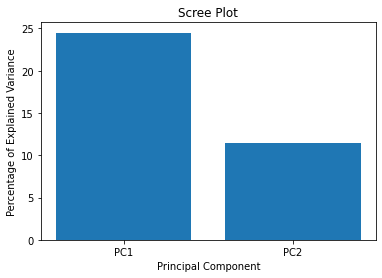

C:\Python39\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<function matplotlib.pyplot.show(close=None, block=None)>

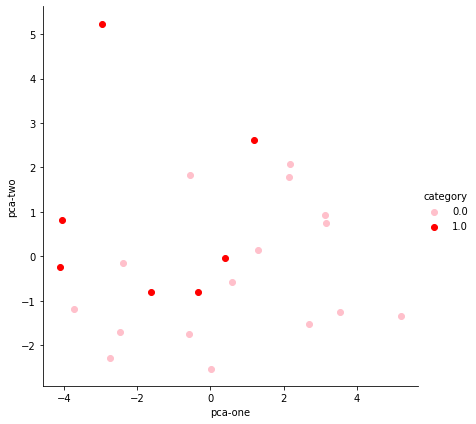

In [339]:
from sklearn.decomposition import PCA
import plotly.express as px

pca = PCA(n_components=2)
pca.fit(X)
principalComponents = pca.transform(X)
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Screen Plot')
plt.show()


import seaborn as sn
pca_data = np.vstack((principalComponents.T, y['category'])).T
pca_df = pd.DataFrame(data=pca_data, columns=("pca-one", "pca-two", "category"))


sn.FacetGrid(pca_df, hue="category", size=6, palette=["pink","red","orange"]).map(plt.scatter, "pca-one", "pca-two").add_legend()
plt.show


In [294]:
def fullNewDataProcessing(df):
    df_prepared = Itinieraire_frequence_pipeline.transform(df)
    df[['Itinéraire','Fréquence']] = pd.DataFrame(df_prepared, columns=['Itinéraire','Fréquencé'], index=df.index)
    df = processNewUsagesApps(df)
    df_array = num_pipeline.transform(df)
    df = pd.DataFrame(df_array, columns=df.columns, index=df.index)
    return df


## 6 - New Data visualisation

In [325]:
#Checking the shape of the dataset
final_data.shape

(23, 29)

In [327]:
#Information about the dataset
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 29 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   Age                                                                       23 non-null     float64
 1   Dépratement                                                               23 non-null     float64
 2   Fréquence                                                                 23 non-null     float64
 3   Itinéraire                                                                23 non-null     float64
 4   Appréciation-portail                                                      23 non-null     float64
 5   Esthétisme                                                                23 non-null     float64
 6   Itinéraire-satisfaction                                             

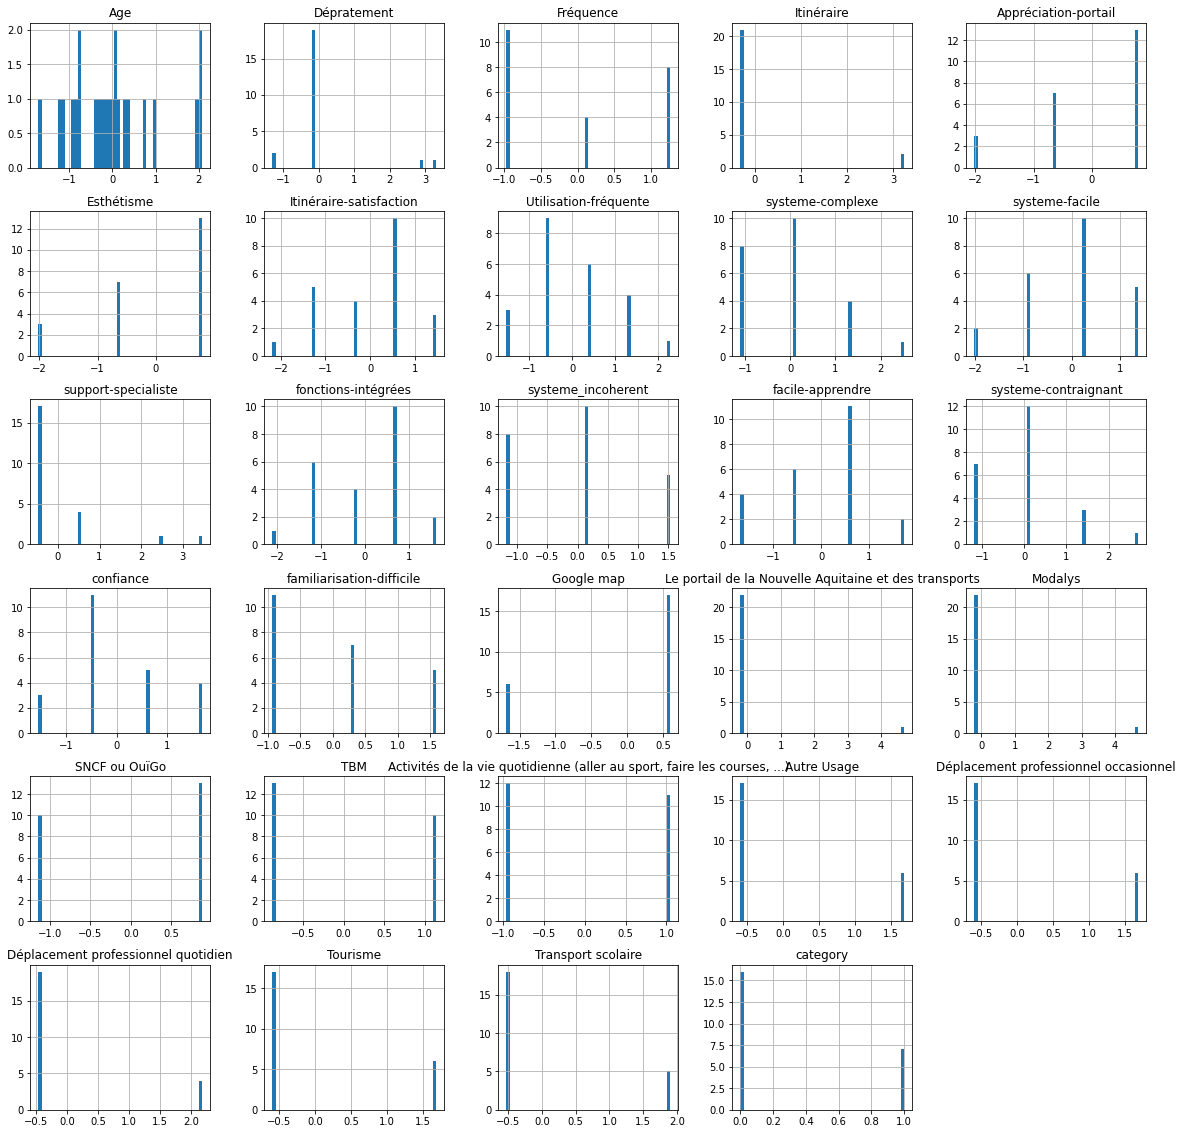

In [297]:
#Plotting the data distribution
final_data.hist(bins = 50,figsize = (20,20))
plt.show()

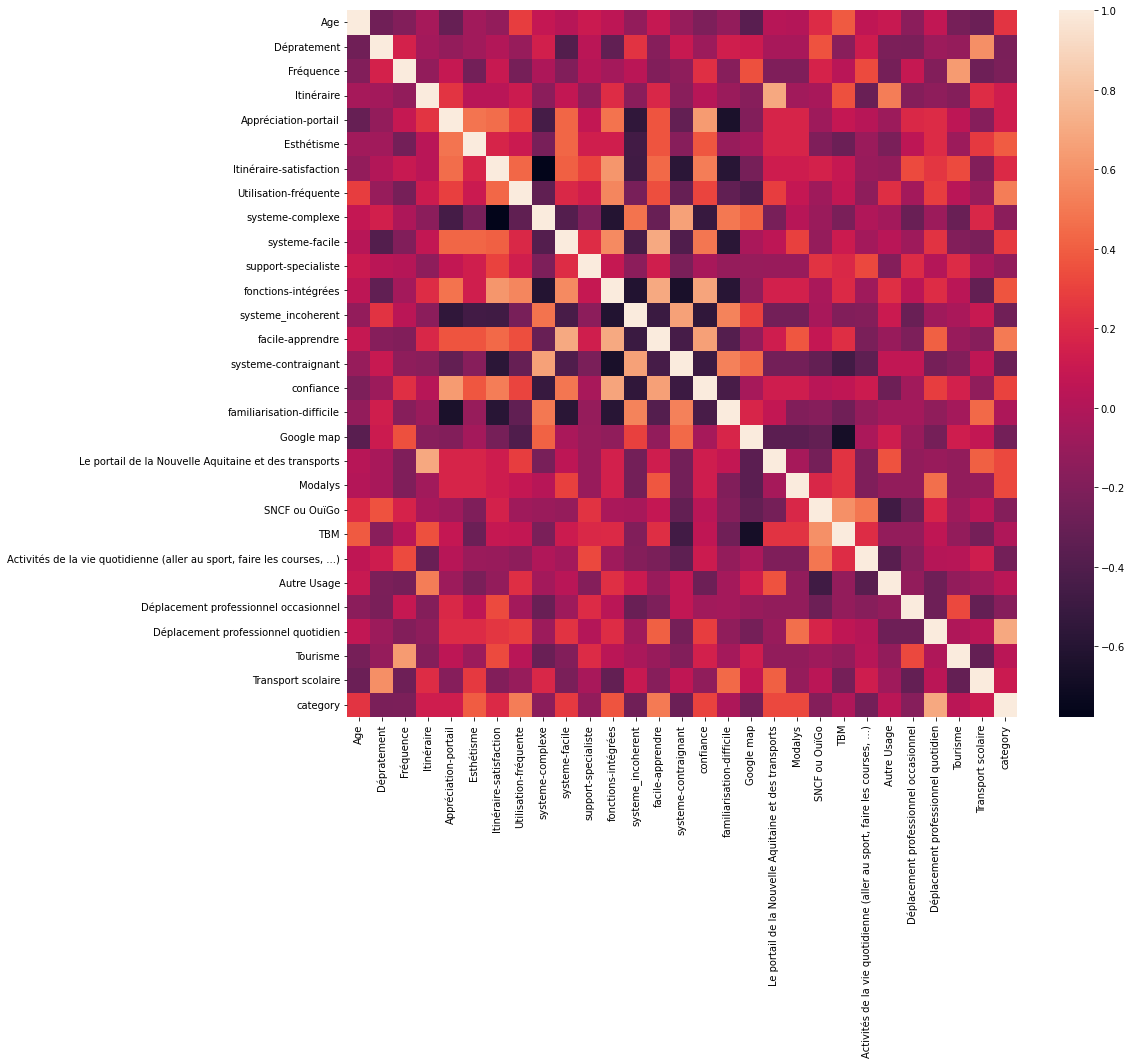

In [328]:
#Correlation heatmap

plt.figure(figsize=(15,13))
sns.heatmap(final_data.corr())
plt.show()

## 7 - Splitting the data

In [329]:
# Splitting the dataset into train and test sets: 80-20 split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, random_state = 12)
X_train.shape, X_test.shape

((18, 28), (5, 28))

## 8 - ML Models 

### 8-1 Linear regression model

In [330]:
#simple linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)


LinearRegression()

In [331]:
y_test_reg = lin_reg.predict(X_test)
y_train_reg = lin_reg.predict(X_train)
lin_mse_train = mean_squared_error(y_train, y_train_reg)
lin_rmse_train = np.sqrt(lin_mse_train)
lin_mse_test = mean_squared_error(y_test, y_test_reg)
lin_rmse_test = np.sqrt(lin_mse_test)
print("regression RMSE score on training set", lin_rmse_train)
print("regression RMSE score on test set", lin_rmse_test)

regression RMSE score on training set 1.7518535228730354e-15
regression RMSE score on test set 0.5029341645120271


In [332]:
scores = cross_val_score(lin_reg, X_train, y_train,
scoring="neg_mean_squared_error", cv=5)
lin_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("regression RMSE scores on cross validation 5-sets", lin_rmse_scores)
    print("Mean:", scores.mean())

display_scores(lin_rmse_scores)  

regression RMSE scores on cross validation 5-sets [0.37371061 0.44365635 0.34925524 0.65846162 0.36361441]
Mean: 0.4377396441481475


In [333]:
ridge_reg = Ridge(alpha=10, solver="cholesky")
ridge_reg.fit(X_train, y_train)


Ridge(alpha=10, solver='cholesky')

In [334]:
#Regularization to avoid overfitting using the ridge linear regression
y_test_ridge = ridge_reg.predict(X_test)
y_train_ridge = ridge_reg.predict(X_train)
ridge_mse_train = mean_squared_error(y_train, y_train_ridge)
ridge_rmse_train = np.sqrt(ridge_mse_train)
ridge_mse_test = mean_squared_error(y_test, y_test_ridge)
ridge_rmse_test = np.sqrt(ridge_mse_test)
print("ridge regression RMSE score on training set", ridge_rmse_train)
print("ridge regression RMSE score on test set", ridge_rmse_test)

ridge regression RMSE score on training set 0.1542415028790099
ridge regression RMSE score on test set 0.4092193379699962


In [342]:
scores = cross_val_score(ridge_reg, X_train, y_train,
scoring="neg_mean_squared_error", cv=5)
ridge_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("ridge regression RMSE scores on cross validation 5-sets", ridge_rmse_scores)
    print("Mean:", scores.mean())

display_scores(ridge_rmse_scores)  

ridge regression RMSE scores on cross validation 5-sets [0.39893379 0.30898584 0.36880916 0.48965089 0.3471822 ]
Mean: 0.3827123775699498


## Multiclass

In [306]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
clf_multi= KNeighborsClassifier()


In [307]:
y_test

,category
7,0
20,0
13,0
16,0
8,0


In [308]:
clf_multi.fit(X_train,y_train['category'])

KNeighborsClassifier()

In [309]:
y_test_multi = clf_multi.predict(X_test)
y_train_multi = clf_multi.predict(X_train)


C:\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [310]:
from sklearn.metrics import accuracy_score
acc_train_multi = accuracy_score(y_train,y_train_multi)
acc_test_multi = accuracy_score(y_test,y_test_multi)

In [311]:
print("Multi_classifier: Accuracy on training Data: {:.3f}".format(acc_train_multi))
print("Multi_classifier: Accuracy on test Data: {:.3f}".format(acc_test_multi))

Multi_classifier: Accuracy on training Data: 0.778
Multi_classifier: Accuracy on test Data: 1.000


In [345]:
scores = cross_val_score(clf_multi, X_train.values, y_train.values,
scoring="accuracy", cv=5)

def display_scores_multi(scores):
    print("K nearest neighbors accuracy scores on cross validation 5-sets", scores)
    print("Mean:", scores.mean())

display_scores_multi(scores)

K nearest neighbors accuracy scores on cross validation 5-sets [0.75       0.5        0.75       0.33333333 0.33333333]
Mean: 0.5333333333333334


C:\Python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fi

### 8-2 Decision tree model

In [313]:
# Decision Tree model 
from sklearn.tree import DecisionTreeClassifier

# instantiate the model 
tree_clf = DecisionTreeClassifier(max_depth = 5)
# fit the model 
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [314]:
#predicting the target value from the model for the samples
y_test_tree = tree_clf.predict(X_test)
y_train_tree = tree_clf.predict(X_train)


In [315]:
#importing packages
from sklearn.metrics import accuracy_score

#computing the accuracy of the model performance
acc_train_tree = accuracy_score(y_train,y_train_tree)
acc_test_tree = accuracy_score(y_test,y_test_tree)

print("Decision Tree: Accuracy on training Data: {:.3f}".format(acc_train_tree))
print("Decision Tree: Accuracy on test Data: {:.3f}".format(acc_test_tree))

test_score = f1_score(y_test, y_test_tree , average="weighted")
training_score = f1_score(y_train, y_train_tree , average="weighted")
print("F1 score on the training data", training_score)
print("F1 score on the test data", test_score)

Decision Tree: Accuracy on training Data: 1.000
Decision Tree: Accuracy on test Data: 0.800
F1 score on the training data 1.0
F1 score on the test data 0.888888888888889


In [346]:
scores = cross_val_score(tree_clf, X_train.values, y_train.values,
scoring="accuracy", cv=5)

def display_scores_multi(scores):
    print("Decision tree accuracy scores on cross validation 5-sets", scores)
    print("Mean:", scores.mean())

display_scores_multi(scores)

Decision tree accuracy scores on cross validation 5-sets [0.75       0.5        1.         0.33333333 0.66666667]
Mean: 0.65


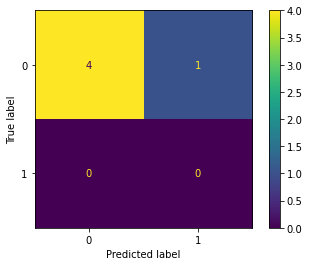

In [ ]:
#plot the confusion matrix for test predictions
cm = confusion_matrix(y_test, y_test_tree, labels=tree_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree_clf.classes_)
disp.plot()
plt.show()

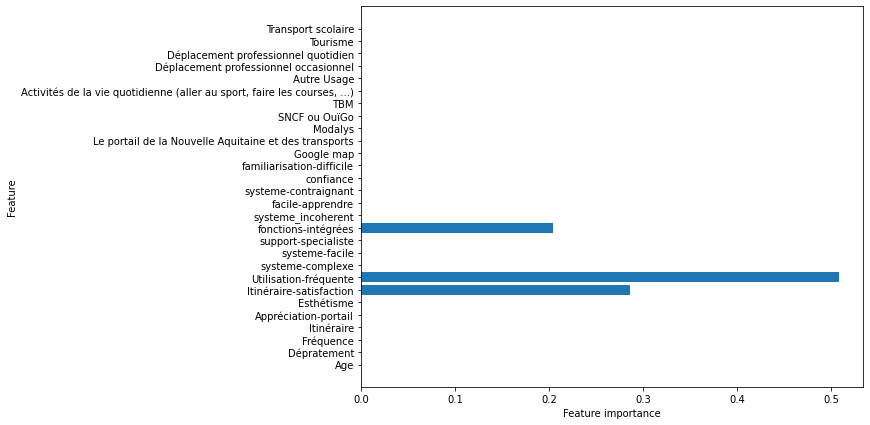

In [335]:
#checking the feature improtance in the model
plt.figure(figsize=(9,7))
n_features = len(X.columns)
plt.barh(range(n_features), tree_clf.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()



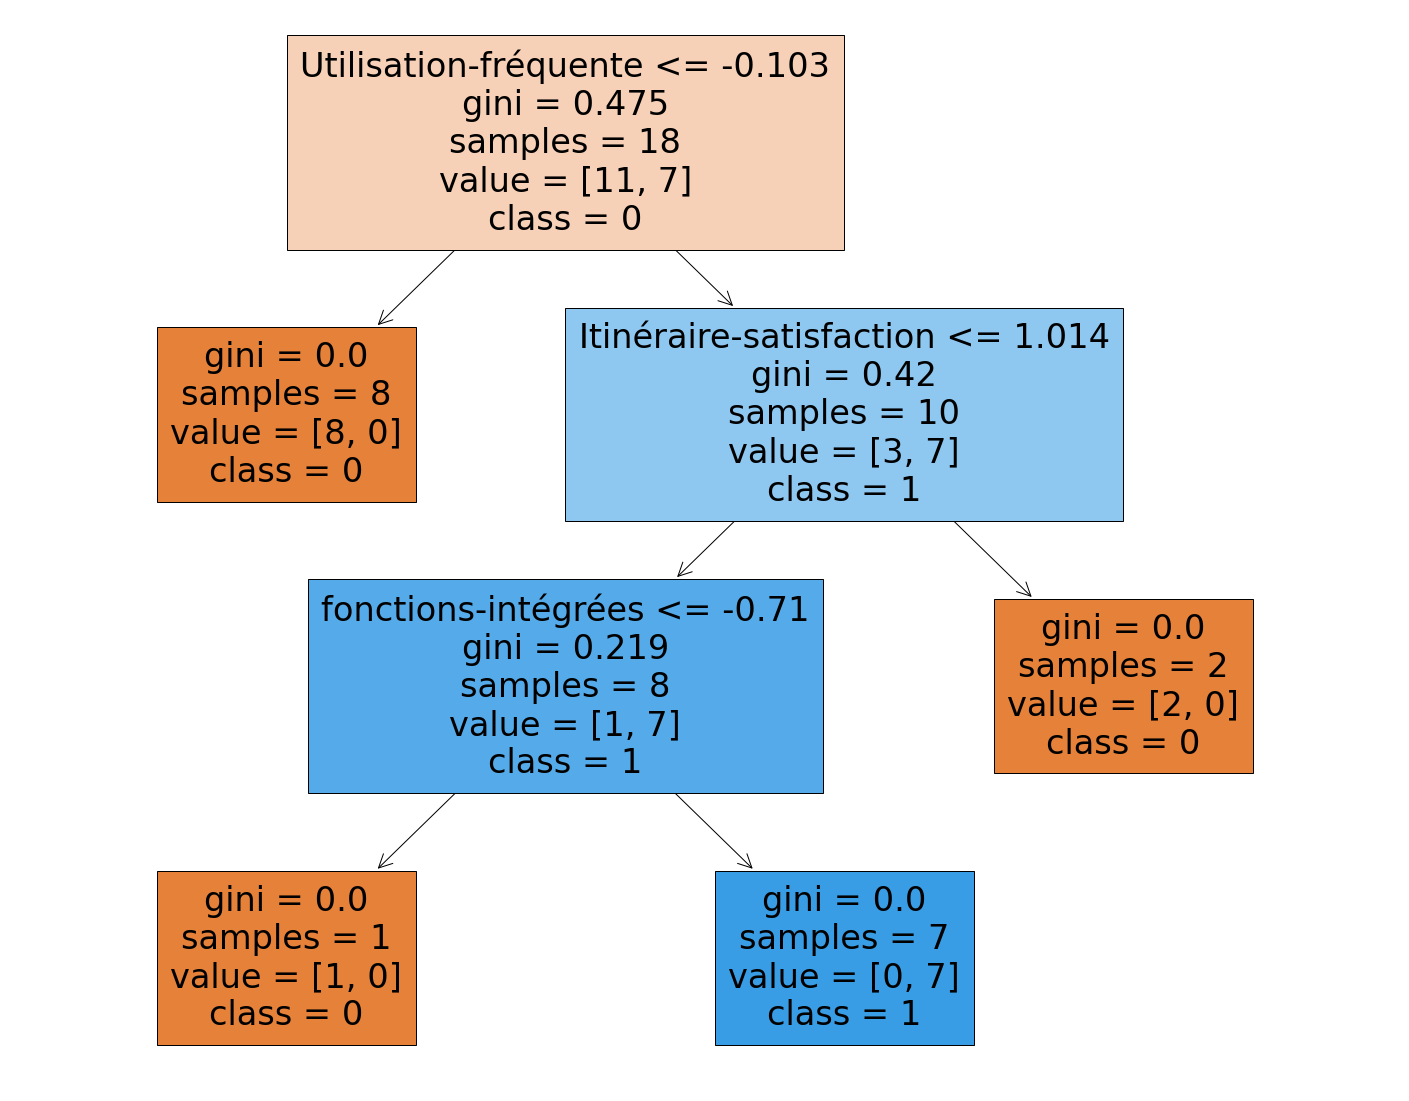

In [336]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(tree_clf,
                   feature_names=X.columns.values.tolist(),  
                   class_names=['0','1','2'],
                   filled=True)


## Perceptron multicouche

In [317]:
from sklearn.neural_network import MLPClassifier

clf_mlp=MLPClassifier(random_state=1, max_iter=300)
clf_mlp.fit(X_train,y_train.values.ravel())

MLPClassifier(max_iter=300, random_state=1)

In [318]:
#predicting the target value from the model for the samples
y_test_mlp = clf_mlp.predict(X_test)
y_train_mlp = clf_mlp.predict(X_train)

In [319]:
#computing the accuracy of the model performance
acc_train_mlp = accuracy_score(y_train,y_train_mlp)
acc_test_mlp = accuracy_score(y_test,y_test_mlp)

print("MLP: Accuracy on training Data: {:.3f}".format(acc_train_mlp))
print("MLP: Accuracy on test Data: {:.3f}".format(acc_test_mlp))

test_score = f1_score(y_test, y_test_mlp , average="weighted")
training_score = f1_score(y_train, y_train_mlp , average="weighted")
print("F1 score on the training data", training_score)
print("F1 score on the test data", test_score)

MLP: Accuracy on training Data: 1.000
MLP: Accuracy on test Data: 0.600
F1 score on the training data 1.0
F1 score on the test data 0.7499999999999999


In [347]:
scores = cross_val_score(clf_mlp, X_train, y_train.values.ravel(),
scoring="accuracy", cv=5)

def display_scores_MLP(scores):
    print("MLP accuracy scores on cross validation 5-sets", scores)
    print("Mean:", scores.mean())

display_scores_MLP(scores)

MLP accuracy scores on cross validation 5-sets [0.75       0.75       0.75       0.66666667 0.33333333]
Mean: 0.65


## Gaussian NB

In [321]:
from sklearn.naive_bayes import GaussianNB

clf_NB=GaussianNB()
clf_NB.fit(X_train,y_train.values.ravel())

GaussianNB()

In [322]:
#predicting the target value from the model for the samples
y_test_nb = clf_NB.predict(X_test)
y_train_nb = clf_NB.predict(X_train)

In [323]:
#computing the accuracy of the model performance
acc_train_nb = accuracy_score(y_train,y_train_nb)
acc_test_nb = accuracy_score(y_test,y_test_nb)

print("NB: Accuracy on training Data: {:.3f}".format(acc_train_nb))
print("NB: Accuracy on test Data: {:.3f}".format(acc_test_nb))

test_score = f1_score(y_test, y_test_nb , average="weighted")
training_score = f1_score(y_train, y_train_nb , average="weighted")
print("F1 score on the training data", training_score)
print("F1 score on the test data", test_score)

NB: Accuracy on training Data: 0.889
NB: Accuracy on test Data: 1.000
F1 score on the training data 0.8842592592592591
F1 score on the test data 1.0


In [348]:
scores = cross_val_score(clf_NB, X_train, y_train.values.ravel(),
scoring="accuracy", cv=5)

def display_scores_NB(scores):
    print("Gaussian Naive bayes accuracy scores on cross validation 5-sets", scores)
    print("Mean:", scores.mean())

display_scores_NB(scores)

Gaussian Naive bayes accuracy scores on cross validation 5-sets [0.75       0.5        0.75       0.66666667 1.        ]
Mean: 0.7333333333333333
